# Data Exploration

This notebook loads in the joint embedding space generated by the Arcadia Science Pub *"Comparing gene expression across species based on protein structure instead of sequence"* into scanpy for browsing and exploration.

---
## 0. Load Dependencies
Load the notebook's dependencies.

In [1]:
import os
import scanpy as sc
import pandas as pd
import arcadia_pycolor as apc

---
## 1. Load genes x cells matrix

Choose whether to use mode `'OG'` to view the orthogroup space or `'SC'` to view the structural cluster space.

In [2]:
mode = 'OG'

########################################

OG_file = 'binder_files/DrerMmusXlae_adultbrain_asOrthogroup_combined_exc_subsampled.h5ad'
SC_file = 'binder_files/DrerMmusXlae_adultbrain_asStruCluster_combined_exc_subsampled.h5ad'

if mode == 'OG':
    input_file = OG_file
elif mode == 'SC':
    input_file = SC_file

# read h5ad file and transpose it to be the right format for scanpy
adata = sc.read_h5ad(input_file)
adata = adata.transpose()

---
## 2. Read cell type annotations

Load the cell type annotations and add them, along with species information, to the scanpy `adata` object.

In [3]:
# get cell barcodes from scanpy anndata
cell_barcodes = pd.DataFrame({'cell_barcode': adata.obs.index})

# create empty collector dataframe
annot_df = pd.DataFrame()

# iterate through cell annotation files
for file in [os.path.join('binder_files', f) for f in os.listdir('binder_files') if '.tsv' in f]:
    sp_prefix = os.path.basename(file).split('_')[0]
    sp_annot_df = pd.read_csv(file, sep = '\t')
    sp_annot_df['cell_barcode'] = sp_prefix + '_' + sp_annot_df['cell_barcode']
    sp_annot_df['celltype'] = sp_prefix + '_' + sp_annot_df['celltype']
    
    annot_df = pd.concat([annot_df, sp_annot_df])

# reorder cell annotations based on order in scanpy anndata
cell_annots = cell_barcodes.merge(annot_df, on = 'cell_barcode', how = 'left')
cell_annots.fillna('Unlabeled', inplace = True)

adata.obs['celltype'] = cell_annots['celltype'].values
adata.obs['species'] = [x.split('_')[0] for x in adata.obs.index.values]

## 3. Filtering

Filter cells based on number of genes; normalize and scale data.  
These parameters are identical to those used in the pub.  

/home/ec2-user/miniconda3/envs/glial_origins/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


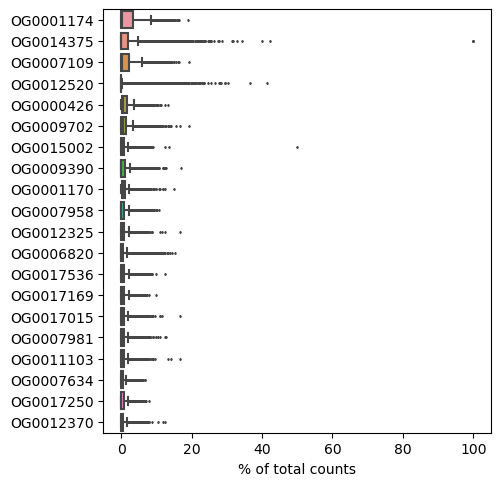

/home/ec2-user/miniconda3/envs/glial_origins/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
# show highest expressing genes
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# filter cells by minimum number of genes and cells
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=20)

# remove cells with very high numbers of genes, normalize
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

# choose highly variable genes
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.1, max_disp = 10)

# regress and scale counts
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata, max_value = 10)

---
## 4. Dimensionality reduction, harmonization, clustering

Perform PCA and use Harmony to "batch correct" across species.

In [5]:
# run PCA
sc.tl.pca(adata, svd_solver='arpack')

# "batch correct" for species using Harmony
sc.external.pp.harmony_integrate(adata, 'species')

# perform dimensionality reduction and clustering
sc.pp.neighbors(adata, n_neighbors=50, n_pcs = 40, use_rep='X_pca_harmony')
sc.tl.umap(adata)
sc.tl.leiden(adata)

2023-06-27 23:20:41,191 - harmonypy - INFO - Iteration 1 of 10
2023-06-27 23:20:54,995 - harmonypy - INFO - Iteration 2 of 10
2023-06-27 23:21:08,739 - harmonypy - INFO - Converged after 2 iterations


---
## 4. Load Colors

The dictionaries below generate palettes for plotting that are identical to those used in the pub.

In [6]:
species_palette = {'Drer': 'arcadia:aster', 'Mmus': 'arcadia:rose', 'Xlae': 'arcadia:seaweed'}

cluster_palette = list(apc.Accent_all_ordered.keys()) + ['arcadia:crow', 'arcadia:bark', 'arcadia:lightgrey']

drer_celltype_palette = {
    # unlabeled, lightgrey
    'Unlabeled': apc.Core['arcadia:lightgrey'],
    
    # myeloid cells, dragon-orange-rose-amber
    'Erythrocyte': apc.adjust_lightness(apc.Accent_all['arcadia:dragon'], 0.8),
    'Innate_immune_cell': apc.Accent_all['arcadia:orange'],
    'Granulocyte': apc.Accent_all['arcadia:rose'],
    'Macrophage': apc.Accent_all['arcadia:amber'],
    'Macrophage_grn1_high': apc.adjust_lightness(apc.Accent_all['arcadia:dress'], 1),
    
    # lymphoid cells, 
    'T_cell': apc.adjust_lightness(apc.Accent_all['arcadia:marineblue'], 1),
    
    # radial glia: lime-sage
    'Regenerating_Radial_gliacell': apc.Accent_all['arcadia:sage'],
    'Radial_glia': apc.Accent_all['arcadia:lime'],
    'Radial_glia_mdkb_high': apc.adjust_lightness(apc.Accent_all['arcadia:lime'], 0.6),
    'Quiescent_Radial_gliacell': apc.adjust_lightness(apc.Accent_all['arcadia:lime'], 0.3),
    
    # microglia, aster-periwinkle
    'Microglia': apc.Accent_all['arcadia:periwinkle'],
    'Microglia_apoc1_high': apc.Accent_all['arcadia:aster'],
    'Proliferating_cell': apc.adjust_lightness(apc.Accent_all['arcadia:periwinkle'], 0.7),
    
    # epithelial cells, aegean-wish-vitalblue
    'Epithelial_cell': apc.adjust_lightness(apc.Accent_all['arcadia:aegean'], 0.8),
    'Epithelial_cell_krt5_high': apc.Accent_all['arcadia:vitalblue'],
    'Meningeal_mural_lymphatic_endothelial_cell': apc.Accent_all['arcadia:bluesky'],
    
    # oligodendrocytes: chateau-taupe
    'Oligodendrocyte': apc.adjust_lightness(apc.Accent_all['arcadia:chateau'], 0.7),
    'Oligodendrocyte_sla_high': apc.Accent_all['arcadia:taupe'],
    
    # neuron: seaweed-mint-forest
    'Neuron': apc.Accent_all['arcadia:seaweed'],
    'Neuron_kiss_high': apc.adjust_lightness(apc.Accent_all['arcadia:seaweed'], 0.6),
    'Neuroblast': apc.adjust_lightness(apc.Core['arcadia:forest'], 0.8),
    'Neural_stem_cell': apc.Accent_all['arcadia:mint'],
    'Neural_progenitor_cell': apc.adjust_lightness(apc.Accent_all['arcadia:sage'], 0.6),
}
mmus_celltype_palette = {
    # unlabeled, lightgrey
    'Unlabeled': apc.Core['arcadia:lightgrey'],
    
    'Macrophage_Lyz2 high': apc.Accent_all['arcadia:amber'],
    'Macrophage_Klf2 high': apc.adjust_lightness(apc.Accent_all['arcadia:dress'], 1),

    'Myelinating oligodendrocyte': apc.adjust_lightness(apc.Accent_all['arcadia:chateau'], 0.7),
    'Oligodendrocyte precursor cell': apc.Accent_all['arcadia:taupe'],
    'Schwann cell': apc.adjust_lightness(apc.Accent_all['arcadia:chateau'], 0.5),
    
    'Neuron': apc.Accent_all['arcadia:seaweed'],
    'Pan-GABAergic': apc.adjust_lightness(apc.Core['arcadia:forest'], 1),
    
    'Astrocyte_Atp1b2 high': apc.adjust_lightness(apc.Accent_all['arcadia:lime'], 1),
    'Astrocyte_Mfe8 high': apc.adjust_lightness(apc.Accent_all['arcadia:lime'], 0.3),
    'Astroglial cell(Bergman glia)': apc.adjust_lightness(apc.Accent_all['arcadia:lime'], 0.6),
    'Hypothalamic ependymal cell': apc.Accent_all['arcadia:sage'],
    
    'Microglia': apc.Accent_all['arcadia:periwinkle'],
}
xlae_celltype_palette = {
    # unlabeled, lightgrey
    'Unlabeled': apc.Core['arcadia:lightgrey'],
    
    # myeloid cells, dragon-orange-rose-amber
    'Erythrocyte': apc.adjust_lightness(apc.Accent_all['arcadia:dragon'], 0.8),
    'Proliferating myeloid cell': apc.adjust_lightness(apc.Accent_all['arcadia:mars'], 1),
    'Eosinophil': apc.Accent_all['arcadia:rose'],
    'Macrophage': apc.Accent_all['arcadia:amber'],
    'Mast cell': apc.adjust_lightness(apc.Accent_all['arcadia:rose'], 0.3),
    
    # lymphoid cells
    'Antigen-presenting cell': apc.adjust_lightness(apc.Accent_all['arcadia:marineblue'], 0.7),
    'T progenitor cell': apc.adjust_lightness(apc.Accent_all['arcadia:denim'], 1),
    'CD8+ T cell': apc.adjust_lightness(apc.Accent_all['arcadia:marineblue'], 1),
    'Plasma B cell': apc.adjust_lightness(apc.Accent_all['arcadia:denim'], 0.5),
    
    # endocrine cells
    'Growth hormone progenitor cell': apc.adjust_lightness(apc.Accent_all['arcadia:wish'], 1),
    'Growth hormone cell_hnrnpk high': apc.adjust_lightness(apc.Accent_all['arcadia:wish'], 0.8),
    'Growth hormone cell_rasd1 high': apc.adjust_lightness(apc.Accent_all['arcadia:wish'], 0.6),
    'Growth hormone cell_Rp high': apc.adjust_lightness(apc.Accent_all['arcadia:wish'], 0.4),
    'Thyrotroph cell': apc.Neutral['arcadia:bark'],
    'Gonadotroph cell_cga high': apc.adjust_lightness(apc.Accent_all['arcadia:blossom'], 1),
    'Gonadotroph cell_cyp21a2.1 high': apc.adjust_lightness(apc.Accent_all['arcadia:blossom'], 0.8),
    'Endocrine progenitor cell_st6galnac2 high': apc.adjust_lightness(apc.Accent_all['arcadia:orange'], 0.7),
    'Endocrine progenitor cell_chgb high': apc.adjust_lightness(apc.Accent_all['arcadia:orange'], 0.5),
    'Melanotrope cell': apc.Neutral['arcadia:crow'],
    'Prolactin progenitor cell': apc.adjust_lightness(apc.Accent_all['arcadia:canary'], 0.6),
    
    # neuron: seaweed-mint-forest
    'Excitatory neuron_tac1 high': apc.Accent_all['arcadia:seaweed'],
    'Excitatory neuron_zbtb18 high': apc.Accent_all['arcadia:mint'],
    'Excitatory neuron_mex3a high': apc.adjust_lightness(apc.Accent_all['arcadia:seaweed'], 0.6),
    'GABAergic neuron_tac1 high': apc.adjust_lightness(apc.Core['arcadia:forest'], 1),
    'GABAergic neuron_scgn high': apc.adjust_lightness(apc.Core['arcadia:forest'], 1.1),
    'GABAergic neuron_sst high': apc.adjust_lightness(apc.Core['arcadia:forest'], 1.2),
    
    # oligodendrocytes: chateau-taupe
    'Myelinating oligodendrocyte progenitor cell': apc.adjust_lightness(apc.Accent_all['arcadia:chateau'], 0.7),
    'Oligodendrocyte precursor cell': apc.Accent_all['arcadia:taupe'],
    
    # astrocytes
    'Fibrous astrocyte': apc.Accent_all['arcadia:sage'],
    'Astrocyte_slc1a3 high': apc.adjust_lightness(apc.Accent_all['arcadia:lime'], 0.6),
    'Astrocyte_adcyap1r1 high': apc.adjust_lightness(apc.Accent_all['arcadia:lime'], 0.3),
    'Radial glia': apc.Accent_all['arcadia:lime'],
    
    # endothelial cell
    'Capillary endothelial cell': apc.adjust_lightness(apc.Accent_all['arcadia:bluesky'], 0.7),
    'Endothelial cell': apc.Accent_all['arcadia:bluesky'],
    
    # other
    'Rp_high': apc.Accent_all['arcadia:oat'],
    'Rod photoreceptor':  apc.Accent_all['arcadia:canary'],
    
    # microglia
    'Microglia': apc.Accent_all['arcadia:periwinkle'],
    'Proliferating cell': apc.adjust_lightness(apc.Accent_all['arcadia:periwinkle'], 0.7),
}

drer_celltype_palette_pre = {'Drer_' + key: value for key, value in drer_celltype_palette.items()}
mmus_celltype_palette_pre = {'Mmus_' + key: value for key, value in mmus_celltype_palette.items()}
xlae_celltype_palette_pre = {'Xlae_' + key: value for key, value in xlae_celltype_palette.items()}

full_celltype_palette = drer_celltype_palette_pre | mmus_celltype_palette_pre | xlae_celltype_palette_pre | {'Unlabeled': 'arcadia:lightgrey'}

## 5. Plot each individual data type as its own plot

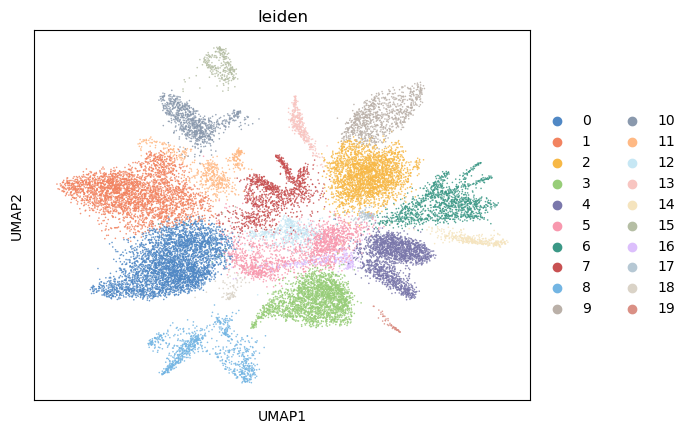

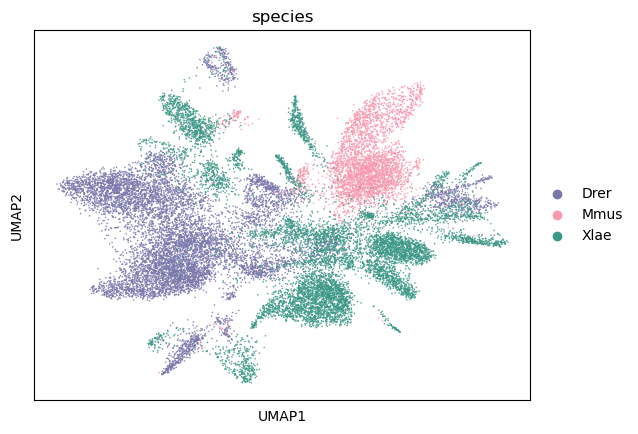

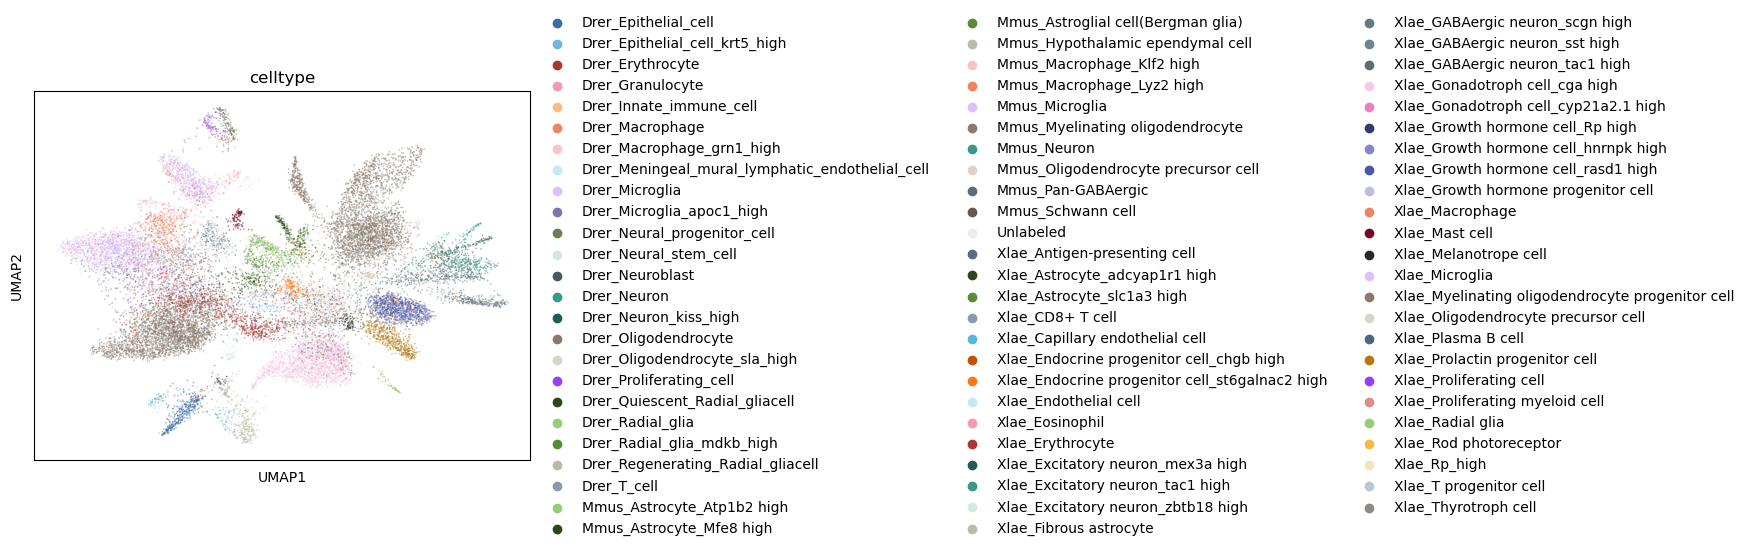

In [7]:
sc.pl.umap(adata, alpha = 0.85, color = 'leiden', palette = cluster_palette)
sc.pl.umap(adata, alpha = 0.85, color = 'species', palette = species_palette)
sc.pl.umap(adata, alpha = 0.5, color = 'celltype', palette = full_celltype_palette)